<a href="https://colab.research.google.com/github/iridescen7/-6655-Final-Project/blob/main/Final_Project_HaokunChen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

**Overview**

Since the early 1990s, China has formed a convention for the national President to present a New Year Address each year. The addresses reflect key achievements and critical challenges in the past year and objectives for the upcoming year. Thus, analyzing the text of each year’s address could provide a lens to investigate how rhetoric and political objectives has evolved over different periods and under different leaders.


**Research Questions**

This project focuses on the following questions:
1. How have the priorities, rhetorical strategies, and policy signals in China’s New Year Addresses shifted over time?
2. What do these trajectories reveal about different leaders, policy agenda, and political dynamics within the Chinese Party-state?


**Relevance**

The text analysis on Chinese New Year Addresses is of vital importance, due to the following reasons:
1. The Chinese government is often considered a "black box", with limited transparency that obstructs examination of its internal dynamics or policy priorities.
2. While New Year Addresses are symbolic in form, the choices of specific words (known as ["tifa"](https://www.rand.org/pubs/research_reports/RRA3821-1.html)) carry important messages, which could be interpreted by officials from different levels of government.
3. There has been a major shift in China's development strategies and ideological path during the term of President Xi Jinping. Focusing on rhetoric and unveil when and how this shift took place.

**Method**

In order to conduct text analysis of New Year Addresses, this project will mainly maneuver methods involved in the third course:
1. TF-IDF: mainly using cosine similarity and PCA to locate the speeches in a two-dimensional space, therefore allowing us to compare them based on proximity.
2. Topic Modeling: Using LDA to uncover deeper thematic structures, in order to dive into the key differences among the speeches, thus providing a more vivid look into how priorities have shifted.

## Environment Setup

The following part has been modified from the codes provided in *The Third Class: Intro_Text_Analysis_TFIDF_LDA_Inaugurals.ipynb*

In [21]:

#Install packages
!pip -q install "numpy==2.0.2" "scikit-learn>=1.4"
!pip install nltk==3.9.2

In [22]:
#Import packages
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA, LatentDirichletAllocation

!pip -q install plotly

import plotly.graph_objects as go


In [23]:
#Preparing Google Drive
from google.colab import drive
drive.mount('/content/drive')

#Creating folder
import os

folder_name = "Chinese New Year Speech"
drive_path = "/content/drive/MyDrive/6655"
corpus_dir = os.path.join(drive_path, folder_name)

os.makedirs(corpus_dir, exist_ok=True)
print(f"✅ Folder ready: {corpus_dir}")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Folder ready: /content/drive/MyDrive/6655/Chinese New Year Speech


## Building Corpus

Because there hasn't been a existing corpus of these speeches, I would have to first build a corpus.

I first tried to use **scraping** to retrieve the texts of each year's New Year Addresses. However, due to the Chinese government’s firewall, inconsistent website structures, and frequent anti-scraping measures on official portals, automated retrieval proved unreliable and incomplete, as the scraping only succeeded in retrieving 2 of the 24 speeches.

As a result, I manually collected the full text of each speech to ensure data accuracy and consistency across years. I also added a column to signify the President who gave the address.

Because of the various differences in wording between Chinese and English, as well as the potential significance that might be carried by nuanced usages of some particular words, this project will first be conducted with Chinese materials, and only be translated into English when it comes to interpreting outcomes and implications.

The collected corpus is as follows:


In [24]:
df = pd.read_csv("/content/drive/MyDrive/6655/China/china_newyear_speeches_full_en.csv")
df.head()

,year,president,url,text
0,1992,Yang Shangkun,https://www.krzzjn.com/show-2945-138642.html,女士们、先生们、朋友们：\n\n 在岁序更新之际，我通过中国国际广播电台，向海外各位朋友致...
1,1993,Yang Shangkun,https://www.krzzjn.com/show-2945-138643.html,各位听众朋友：\n\n 1993年来到了，我很高兴再次通过中国国际广播电台向各国朋友、...
2,1994,Jiang Zemin,https://www.krzzjn.com/show-2945-138644.html,女士们，先生们，朋友们：\n\n 在1994年到来之际，我很高兴在北京通过中国国际广播电台...
3,1995,Jiang Zemin,https://www.krzzjn.com/show-2945-138645.html,女士们、先生们、朋友们：\n\n 在1995年到来之际，我很高兴再次通过中国国际广播电台，...
4,1996,Jiang Zemin,https://www.krzzjn.com/show-2945-138646.html,女士们、先生们、朋友们：\n\n 在这辞旧迎新的美好时刻，我很高兴通过中国国际广播电台和中...


## Cleaning Text

Because stopwords in Chinese is different from those in English, an exterior stopword list needs to be imported.

While there are various existing Chinese stopword lists, [research](https://archive.org/details/ChinaXiv-201711.01949V1/page/n1/mode/2up) indicates that the Baidu stopword list has the best performance in areas of Economy, Military and highest overall performance.

Therefore, [the Baidu stopword list](https://github.com/goto456/stopwords) is used in this project.

The following part has been modified from the codes provided in *The Third Class: Intro_Text_Analysis_TFIDF_LDA_Inaugurals.ipynb*

In [25]:
#Load stopword list

import jieba

with open("/content/drive/MyDrive/6655/China/baidu_stopwords.txt", "r", encoding="utf-8") as f:
    CN_STOP = set([line.strip() for line in f])


In order to optimize the effect of text analysis, I first used only the Baidu stopword list to run a sanity check. After that, I went through the top 500 words with highest frequency and manually added them to a customized stopword lists.

It's notable that while some words do not carry substantial meaning, for example, "挑战"("Challenge"), "希望"("Hope"), there are words that might seem meaningless but are key political signals in Chinese political contexts, like "增长"("Growth")，which mainly reflects the ideological pathway of Deng Xiaoping that is more liberal and centralizes economic development, vis-a-vis other approaches that place more emphasis on political control or domestic stability.

In total, there are about 368 custom stopwords added.

In [26]:
#Customizing stopwords
CUSTOM_STOP = {
    '女士们', '先生们', '朋友们', '朋友', '各位', '听众', '观众', '朋友们',
    '中国国际广播电台', '中央电视台',
    '到来之际', '辞旧迎新', '美好', '时刻', '岁序更新',
    '祝愿', '致以', '问候', '再次', '高兴', '通过', '来到',
    '祝福','周年','钟声','海外侨胞','群众','谢谢',
    '敲响','不少','早日','世纪','新世纪','永远','百年','就要',
    '中央人民广播电台','全体',
    '这是','到来','国内','在内','中国政府','很多','各项','一路','新年快乐',
    '中国', '人民', '国家', '我国', '全国', '祖国',
    '各国', '各族人民', '台湾同胞', '港澳同胞','各位朋友',
    '新年', '一年', '一个',
    '北京', "社会","推进","推动","努力","历史","维护","地区","事业","中华民族","中国共产党","进一步","挑战","方针","时代","即将","作出","希望","改善","贡献","坚定不移","奋斗","面临","一道","长期","加快","进程","持续","着力","民族","建立","发生","困难","胜利","工作","政治","成就","基础","未来","应对","提高","奉行","解决","领导人","目标","平凡","会议","主题","成功","力量","增强","活力","实施","情况","成立","高度","机遇","命运","变化","来说","特别","包括","必将","带来","顺利","方式","高举","战胜","始终","安康","发挥","作用","支持","活动","共同努力","始终不渝","举办","征程","构建","建成","意义","提出","贯彻","面对","战略","日益","步伐","水平","改变","信心","决心","增进","深化","反对","日新月异","崇高","影响","此时此刻","坚定","积极参与","全国代表大会","协调","祝贺","大国","振兴","趋势","恢复","开创","参加","精神","迎来","成果","提供","复兴","同情","共享","真诚","之际","成绩","我愿","进展","经验","依然","历史性","领导","迈出","快速","纪念","总体","迎接","美好未来","家园","部署","热点问题","隆重庆祝","保障","不负","地位","更好","借此机会","人员","衷心","共识","坚信","明天","前景","关心","走向","富强","共同愿望","两个","致力于","苦难","时期","一系列","前途","分裂","伟大旗帜","克服","万众一心","做好","正式","千年","才能","动力","调整","愿同","造福","基本方针","思想","开局","严峻","力所能及","无数","付出","老百姓","多万","奉献","期待","收获","地方","衷心祝愿","遭受","政策","诚挚","还要","感到","离不开","差距","结束","消除","迈进","摆脱","原则","相互了解","中华人民共和国","充满","代表","关注","政治家","携起手来","完善","心愿","推向","阶段","煎熬","指导","此起彼伏","衷心希望","深切","重申","干部","汗水","守望相助","梦想","令人","温暖","攻坚","辛苦","长江","前行","风雨","突破","超过","扎实","越来越","感谢","相互","繁荣昌盛","东方","热忱","能力","光明","参与","领域","阻挡","态度","正确","处在","尊重","一如既往","使命","潮流","制造","根本利益","充满信心","艰苦奋斗","一步","势头","之间","现实","自豪","局面","标志","中心","条件","责任","态势","充满希望","不懈努力","机构","措施","保持稳定","展示","政府","智慧","结构","自主","中华儿女","深刻","美好生活","共同利益","首次","旗帜","决不","民众","阳光","贯彻落实","把握","注重","孩子","过得","万亿元","出席","奋斗者","英雄","担当","展现","黄河","传承","变幻","国民","回升","欣欣向荣","事务","满怀信心","团结起来","全面进步","来临","看一看","安定团结","尽早","顺应","指引","党和政府","制定","必由之路","格局","加速","不懈","愿望","团结合作","终于","继续前进","利益","有利于","曙光","不合理","恶化","困扰","值得","时间","跨世纪","蓝图","制度","斗争","切实"

}

STOPWORDS = CN_STOP.union(CUSTOM_STOP)

In [27]:
# Cleaning function
def simple_clean_tokens_cn(text):
    """
    Chinese version:
    1) Normalize text (optional)
    2) Remove punctuation
    3) Jieba segmentation
    4) Remove stopwords
    5) Remove 1-character tokens (optional)
    """
    # Remove punctuation, English letters, numbers
    text = re.sub(r"[^\u4e00-\u9fa5]", " ", text)

    # Jieba segmentation
    tokens = jieba.lcut(text)

    # Remove stopwords and single characters
    clean = [tok for tok in tokens
             if tok not in STOPWORDS
             and len(tok) >= 2]   # Chinese words often 1-2 chars, use >=2 to reduce noise

    return clean

In [28]:
df['tokens'] = df['text'].apply(simple_clean_tokens_cn)
df['text_clean'] = df['tokens'].apply(lambda toks: " ".join(toks))
df[['year', 'text_clean']].head()


,year,text_clean
0,1992,海外 亲切 合家幸福 万事如意 国际风云 急剧 面前 洪涝灾害 表现 信念 显示 极强 凝聚...
1,1993,海外 华侨 华人 拜年 事业成功 生活 幸福 天灾 战乱 蒙受 痛苦 表示慰问 安居乐业 平...
2,1994,海外 华侨 华人 贺意 万事 顺遂 家庭幸福 邓小平 同志 建设 特色 社会主义 理论 党的...
3,1995,海外 华侨 华人 抗日战争 世界反法西斯战争 五十周年 联合国 五十周年 世界 和平 发展 ...
4,1996,世界 发展 刚刚 世界 世界反法西斯战争 抗日战争 联合国 联合国 国际 地区性 组织 回顾...


In [29]:
#Export
df.to_csv(
    "/content/drive/MyDrive/6655/China/china_speech_clean.csv",
    index=False,
    encoding="utf-8-sig"
)

## TF-IDF: Overviewing How Addresses Evolve

In this part, TF-IDF is used to provide a general overview of how speeches are related and similar to one another, mainly through two-dimensional spacing through PCA.

This provides an overview of how rhetoric and policy agenda has shifted, before a more in-depth analysis with LDA.

The following part has been modified from the codes provided in *The Third Class: Intro_Text_Analysis_TFIDF_LDA_Inaugurals.ipynb*

In [30]:
#Building TF-IDF model
tfidf = TfidfVectorizer(
    tokenizer=str.split,
    preprocessor=None,
    lowercase=False,
    min_df=2
)

X_tfidf = tfidf.fit_transform(df['text_clean'])
terms = np.array(tfidf.get_feature_names_out())

print(X_tfidf.shape, len(terms))


(34, 1032) 1032


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



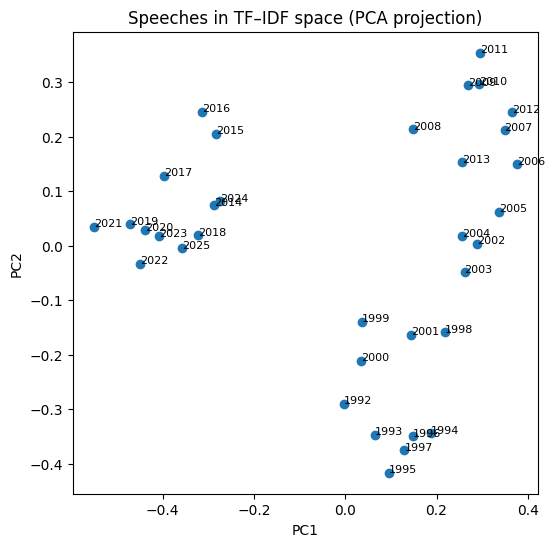

In [31]:
# 2D projection with PCA
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_tfidf.toarray())
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(coords[:,0], coords[:,1])
for i, row in df.iterrows():
    ax.annotate(str(row['year']), (coords[i,0], coords[i,1]), fontsize=8)
ax.set_title("Speeches in TF–IDF space (PCA projection)")
ax.set_xlabel("PC1"); ax.set_ylabel("PC2")
plt.show()


There has already been a significant pattern in terms of how different addresses are related, but to grasp a clearer view, I added lines that connect consecutive years to provide a sense of how the subjects develop in chronological order.

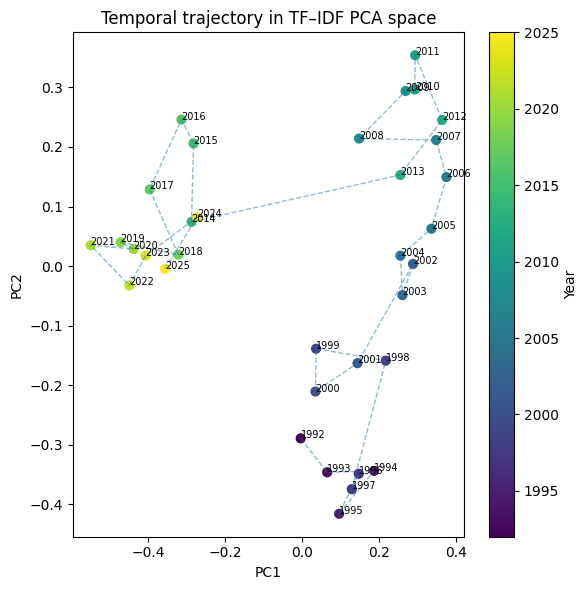

In [32]:
#Adding chronological order
df = df.reset_index(drop=True)
pca = PCA(n_components=2, random_state=42)
coords = pca.fit_transform(X_tfidf.toarray())

order = np.argsort(df['year'].values)
coords_ord = coords[order]
years_ord = df['year'].values[order]

fig, ax = plt.subplots(figsize=(6, 6))

ax.plot(coords_ord[:, 0], coords_ord[:, 1],
        linestyle='--', linewidth=1, alpha=0.5)

sc = ax.scatter(coords_ord[:, 0], coords_ord[:, 1],
                c=years_ord, cmap='viridis', s=40)

for i, (x, y, yr) in enumerate(zip(coords_ord[:, 0], coords_ord[:, 1], years_ord)):
    ax.annotate(str(yr), (x, y), fontsize=7)

cbar = plt.colorbar(sc, ax=ax)
cbar.set_label("Year")

ax.set_title("Temporal trajectory in TF–IDF PCA space")
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
plt.tight_layout()
plt.show()


The PCA visualization reveals a clear temporal trajectory in the linguistic structure of China’s New Year Addresses.

There are two characteristics that this graph highlights:
1. Generally the speeches can be sorted into three categories: 1992-2001, 2002-2013, 2014-2025. This is generally in alignment of the changing leaders, the first period under Yang & Jiang, the second period under Hu, and the third period under Xi.
2. While different themes are highlighted in different periods, there is smooth continuation before and after each transition. In addition, neighboring years tend to lie close to one another, indicating continuity in discourse and a gradual evolution of linguistic priorities rather than sudden breaks.


## LDA: Examining How Transitions Took Place

In this part, LDA is used to provide a more in-depth examination of the changing rhetoric in Chinese New Year Addresses. Thus, we could have a more concrete understanding of what exact topics are highlighted in different periods, instead of barely an abstract overview.

The following part has been modified from the codes provided in *The Third Class: Intro_Text_Analysis_TFIDF_LDA_Inaugurals.ipynb*

First, I use a basic LDA model to check the effectiveness.

In [33]:
#Simple LDA model test
cv = CountVectorizer(
    tokenizer=str.split,
    preprocessor=None,
    lowercase=False,
    min_df=2
)

X_counts = cv.fit_transform(df['text_clean'])
vocab = np.array(cv.get_feature_names_out())

X_counts.shape, len(vocab)


#Train LDA

K = 3

lda = LatentDirichletAllocation(
    n_components=K,
    learning_method="batch",
    random_state=42,
    max_iter=20
)

topic_mix = lda.fit_transform(X_counts)

def show_topics(model, vocab, topn=12):
    for k, comp in enumerate(model.components_):
        top_idx = comp.argsort()[::-1][:topn]
        words = vocab[top_idx]
        print(f"\nTopic {k}: " + "，".join(words))

show_topics(lda, vocab, topn=12)

topic_df = pd.DataFrame(topic_mix, columns=[f"topic_{k}" for k in range(K)])
result_df = pd.concat([df[['year', 'president']], topic_df], axis=1)

result_df.head(25)


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'




Topic 0: 发展，世界，生活，同胞，改革，脱贫，和平，国际，建设，创造，香港，人类

Topic 1: 发展，世界，经济，生活，高质量，文明，现代化，人类，教育，和平，就业，澳门

Topic 2: 发展，世界，和平，经济，建设，国际，合作，社会主义，稳定，同胞，香港，人类


,year,president,topic_0,topic_1,topic_2
0,1992,Yang Shangkun,0.003195,0.003124,0.993682
1,1993,Yang Shangkun,0.002537,0.002475,0.994988
2,1994,Jiang Zemin,0.002270,0.002240,0.995490
3,1995,Jiang Zemin,0.002118,0.002075,0.995806
4,1996,Jiang Zemin,0.001887,0.001876,0.996237
5,1997,Jiang Zemin,0.002183,0.002100,0.995717
6,1998,Jiang Zemin,0.001924,0.001861,0.996215
7,1999,Jiang Zemin,0.001920,0.001877,0.996203
8,2000,Jiang Zemin,0.003020,0.002939,0.994041
9,2001,Jiang Zemin,0.002315,0.002201,0.995484


In [34]:
#Prepare for visualisation
def topic_top_words(lda_model, vocab, topn=10):
    """Return:
       - topic_labels: list like ["T0: economy, growth, jobs", ...]
       - topic_words:  list of lists of the topn words per topic (for hover)
    """
    labels = []
    words_list = []
    for k, comp in enumerate(lda_model.components_):
        top_idx = comp.argsort()[::-1][:topn]
        words = vocab[top_idx].tolist()
        words_list.append(words)
        label = f"T{k}: " + ", ".join(words[:6])
        labels.append(label)
    return labels, words_list

topic_labels, topic_words = topic_top_words(lda, vocab, topn=12)

topic_cols = [c for c in result_df.columns if c.startswith("topic_")]


In [35]:
df_sorted = result_df.sort_values("year").reset_index(drop=True)

mean_by_topic = df_sorted[topic_cols].mean(axis=0).to_numpy()
order = np.argsort(mean_by_topic)[::-1]
ordered_cols = [topic_cols[i] for i in order]
ordered_x = [f"T{int(c.split('_')[-1])}" for c in ordered_cols]

A = df_sorted[ordered_cols].to_numpy()
y_all = df_sorted["year"].astype(str) + " — " + df_sorted["president"]

hovertext_all = []
for r_i, r in df_sorted.iterrows():
    row_texts = []
    for c in ordered_cols:
        k = int(c.split('_')[-1])
        row_texts.append(
            f"<b>{int(r['year'])} — {r['president']}</b><br>"
            f"<b>Topic {k}</b><br>"
            f"Top words: {', '.join(topic_words[k][:10])}<br>"
            f"Proportion: {r[c]:.3f}"
        )
    hovertext_all.append(row_texts)

fig_all = go.Figure(
    data=go.Heatmap(
        z=A,
        x=ordered_x,
        y=y_all,
        colorscale="Plasma",
        zmin=0.0, zmax=1.0,
        hoverinfo="text",
        text=hovertext_all
    )
)
fig_all.update_layout(
    title="All speeches — topic mixture heatmap (topics ordered by prevalence)",
    xaxis_title="Topic",
    yaxis_title="Speech (year — president)",
    height=max(450, 14*len(df_sorted)),
    margin=dict(l=120, r=20, t=60, b=80)
)
fig_all.show()


Since the result provides limited details, the simple LDA model requires further modification.

## Modifying LDA Model

In [36]:
#Modifying parameters
cv = CountVectorizer(
    tokenizer=str.split,
    preprocessor=None,
    lowercase=False,
    min_df=3,
    max_df=0.5
)

X_counts = cv.fit_transform(df['text_clean'])
vocab = np.array(cv.get_feature_names_out())

#Key parameters
K = 3
alpha = 0.1
beta  = 0.01
max_iter = 200

lda = LatentDirichletAllocation(
    n_components=K,
    learning_method="batch",
    random_state=42,
    max_iter=max_iter,
    doc_topic_prior=alpha,
    topic_word_prior=beta,
)

topic_mix = lda.fit_transform(X_counts)


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning:

The parameter 'token_pattern' will not be used since 'tokenizer' is not None'



Testing different K-Value.

In [37]:
#Comparing effectiveness of different K-values
for K in range(3,11):
    lda = LatentDirichletAllocation(
        n_components=K,
        learning_method="batch",
        random_state=42,
        max_iter=100,
        doc_topic_prior=0.1,
        topic_word_prior=0.01,
    )
    lda.fit(X_counts)
    print(f"K={K}, perplexity={lda.perplexity(X_counts):.2f}")
    topic_mix = lda.fit_transform(X_counts)  # (n_docs, K)

    def show_topics(model, vocab, topn=12):
        for k, comp in enumerate(model.components_):
            top_idx = comp.argsort()[::-1][:topn]
            words = vocab[top_idx]
            print(f"\nTopic {k}: " + "，".join(words))

    show_topics(lda, vocab, topn=12)


K=3, perplexity=800.37

Topic 0: 交流，增长，和谐，民生，金融危机，平稳，气候变化，深化改革，推进改革，互利，两岸关系，科学

Topic 1: 和平统一，关系，环境，外交政策，独立自主，增长，秩序，多极化，文明，国民经济，台湾，交流

Topic 2: 脱贫，疫情，高质量，贫困人口，创新，农村，全球，防控，共同体，一带，生命，自由贸易
K=4, perplexity=781.32

Topic 0: 和谐，增长，交流，科学，平稳，互利，金融危机，疾病，澳人治澳，推进改革，国际形势，经济社会

Topic 1: 关系，环境，台湾，独立自主，友好合作，强权政治，统一大业，海外，霸权主义，交往，联合国，国民经济

Topic 2: 脱贫，贫困人口，农村，疫情，创新，全球，共同体，高质量，一带，防控，生命，自由贸易

Topic 3: 文明，和平统一，精神文明，多极化，政治经济，发展中国家，科技进步，恐怖主义，秩序，冲突，全球，增长
K=5, perplexity=919.44

Topic 0: 奥运会，残奥会，灾害，隆重，困难群众，怀念，贫困人口，增长，农村，公平正义，体制改革，发力

Topic 1: 关系，台湾，环境，友好合作，国民经济，秩序，强权政治，统一大业，独立自主，公正，海外，联合国

Topic 2: 脱贫，疫情，创新，贫困人口，防控，农村，生命，共同体，自由贸易，深化改革，全球，初心

Topic 3: 文明，和平统一，精神文明，全球，环境，恐怖主义，安宁，亚洲，独立自主，全球化，外交政策，发展中国家

Topic 4: 交流，和谐，增长，科学，自治，港人治港，互利，澳人治澳，发展观，国际形势，金融危机，平稳
K=6, perplexity=1040.67

Topic 0: 和谐，交流，增长，科学，互利，平稳，发展观，疾病，金融危机，澳人治澳，港人治港，自治

Topic 1: 环境，台湾，关系，强权政治，秩序，国民经济，公正，联合国，统一大业，霸权主义，友好合作，独立自主

Topic 2: 脱贫，疫情，创新，防控，农村，贫困人口，自由贸易，共同体，一带，全球，生命，国产

Topic 3: 和平统一，金融危机，精神文明，安宁，环境，亚洲，全球，深化改革，高质量，教育，就业，两岸关系

Topic 4: 关系，友好合

When K = 3, perplexity is among the lowest, and topic categories do not overlap like when K = 4. So K = 3 will be adopted.



Next, testing different alpha.

In [38]:
#Testing different alpha
for alpha in [0.05, 0.1, 0.2, 0.3]:
    lda = LatentDirichletAllocation(
        n_components=3,
        learning_method="batch",
        random_state=42,
        max_iter=100,
        doc_topic_prior=alpha,
        topic_word_prior=0.01,
    )
    lda.fit(X_counts)
    print(f"alpha={alpha}, perplexity={lda.perplexity(X_counts):.2f}")
    show_topics(lda, vocab, topn=10)


alpha=0.05, perplexity=798.26

Topic 0: 交流，增长，和谐，民生，金融危机，平稳，气候变化，深化改革，推进改革，互利

Topic 1: 和平统一，关系，环境，外交政策，独立自主，增长，秩序，多极化，文明，国民经济

Topic 2: 脱贫，疫情，高质量，创新，贫困人口，全球，农村，防控，共同体，一带
alpha=0.1, perplexity=800.37

Topic 0: 交流，增长，和谐，民生，金融危机，平稳，气候变化，深化改革，推进改革，互利

Topic 1: 和平统一，关系，环境，外交政策，独立自主，增长，秩序，多极化，文明，国民经济

Topic 2: 脱贫，疫情，高质量，贫困人口，创新，农村，全球，防控，共同体，一带
alpha=0.2, perplexity=720.00

Topic 0: 和谐，增长，交流，平稳，科学，互利，澳人治澳，发展观，推进改革，疾病

Topic 1: 和平统一，关系，环境，外交政策，独立自主，文明，秩序，多极化，台湾，国民经济

Topic 2: 脱贫，贫困人口，农村，疫情，创新，全球，高质量，共同体，一带，防控
alpha=0.3, perplexity=721.24

Topic 0: 和谐，增长，交流，科学，平稳，互利，澳人治澳，发展观，推进改革，疾病

Topic 1: 环境，关系，和平统一，独立自主，秩序，外交政策，文明，台湾，国民经济，公正

Topic 2: 脱贫，贫困人口，农村，疫情，创新，全球，高质量，共同体，一带，防控


When alpha = 0.3, topic categories make most sense. So alpha = 0.3 will be adopted.

Next, testing different beta.

In [39]:
#Testing different beta
alpha = 0.3
for beta in [0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1]:
    lda = LatentDirichletAllocation(
        n_components=3,              # 你前面设定的 K，比如 3
        learning_method="batch",
        random_state=42,
        max_iter=100,                # 可以设置大一点
        doc_topic_prior=0.1,       # 你已经设定的 alpha
        topic_word_prior=beta,       # <= 我们要测试的重点
    )
    lda.fit(X_counts)
    print(f"beta={beta}, perplexity={lda.perplexity(X_counts):.2f}")
    show_topics(lda, vocab, topn=10)

beta=0.005, perplexity=866.44

Topic 0: 和谐，增长，交流，平稳，科学，互利，澳人治澳，发展观，推进改革，疾病

Topic 1: 和平统一，关系，环境，外交政策，独立自主，秩序，多极化，文明，台湾，国民经济

Topic 2: 脱贫，贫困人口，农村，疫情，创新，全球，高质量，共同体，一带，防控
beta=0.01, perplexity=800.37

Topic 0: 交流，增长，和谐，民生，金融危机，平稳，气候变化，深化改革，推进改革，互利

Topic 1: 和平统一，关系，环境，外交政策，独立自主，增长，秩序，多极化，文明，国民经济

Topic 2: 脱贫，疫情，高质量，贫困人口，创新，农村，全球，防控，共同体，一带
beta=0.02, perplexity=668.63

Topic 0: 交流，增长，和谐，民生，金融危机，平稳，气候变化，推进改革，深化改革，互利

Topic 1: 和平统一，关系，环境，外交政策，独立自主，增长，秩序，多极化，文明，国民经济

Topic 2: 脱贫，疫情，贫困人口，高质量，创新，农村，全球，防控，共同体，一带
beta=0.05, perplexity=541.32

Topic 0: 交流，增长，和谐，民生，金融危机，平稳，气候变化，推进改革，互利，深化改革

Topic 1: 和平统一，关系，环境，外交政策，独立自主，增长，秩序，多极化，文明，国民经济

Topic 2: 脱贫，疫情，贫困人口，高质量，创新，农村，全球，防控，共同体，一带
beta=0.1, perplexity=473.12

Topic 0: 交流，增长，和谐，民生，金融危机，平稳，气候变化，推进改革，互利，深化改革

Topic 1: 和平统一，关系，环境，外交政策，独立自主，增长，秩序，多极化，文明，国民经济

Topic 2: 脱贫，疫情，贫困人口，高质量，农村，创新，全球，防控，共同体，一带
beta=0.2, perplexity=414.54

Topic 0: 交流，增长，和谐，金融危机，推进改革，平稳，深化改革，奥运会，气候变化，互利

Topic 1: 和平统一，关系，外交政策，独立自主，环境，增长，多极化，国民经济，台湾，秩序

Topic 2: 脱贫，疫情，贫困人口，全球，高质量

When beta = 0.01, topic categories make most sense. So beta = 0.01 will be adopted.

In conclusion, LDA works best with K = 3, alpha = 0.3, beta = 0.01.

Now redo LDA and check how results are different.

In [40]:
#Adopting new values for parameters
cv = CountVectorizer(
    tokenizer=str.split,
    preprocessor=None,
    lowercase=False,
    min_df=3,
    max_df=0.5
)

X_counts = cv.fit_transform(df['text_clean'])
vocab = np.array(cv.get_feature_names_out())

K = 3
alpha = 0.3
beta  = 0.01
max_iter = 200

lda = LatentDirichletAllocation(
    n_components=K,
    learning_method="batch",
    random_state=42,
    max_iter=max_iter,
    doc_topic_prior=alpha,
    topic_word_prior=beta,
)

topic_mix = lda.fit_transform(X_counts)


def show_topics(model, vocab, topn=12):
    for k, comp in enumerate(model.components_):
        top_idx = comp.argsort()[::-1][:topn]
        words = vocab[top_idx]
        print(f"\nTopic {k}: " + "，".join(words))

show_topics(lda, vocab, topn=12)

topic_df = pd.DataFrame(topic_mix, columns=[f"topic_{k}" for k in range(K)])
result_df = pd.concat([df[['year', 'president']], topic_df], axis=1)

def topic_top_words(lda_model, vocab, topn=10):
    """Return:
       - topic_labels: list like ["T0: economy, growth, jobs", ...]
       - topic_words:  list of lists of the topn words per topic (for hover)
    """
    labels = []
    words_list = []
    for k, comp in enumerate(lda_model.components_):
        top_idx = comp.argsort()[::-1][:topn]
        words = vocab[top_idx].tolist()
        words_list.append(words)
        label = f"T{k}: " + ", ".join(words[:6])
        labels.append(label)
    return labels, words_list

topic_labels, topic_words = topic_top_words(lda, vocab, topn=12)

topic_cols = [c for c in result_df.columns if c.startswith("topic_")]

rows = [0, len(result_df)//2, len(result_df)-1]
df_sel = result_df.iloc[rows].copy()

Z = df_sel[topic_cols].to_numpy()
x = [f"T{int(c.split('_')[-1])}" for c in topic_cols]
y = [f"{r.year} — {r.president}" for _, r in df_sel.iterrows()]

hovertext = []
for r_i, r in df_sel.iterrows():
    row_texts = []
    for t_i, col in enumerate(topic_cols):
        k = int(col.split('_')[-1])
        row_texts.append(
            f"<b>{int(r.year)} — {r.president}</b><br>"
            f"<b>Topic {k}</b><br>"
            f"Top words: {', '.join(topic_words[k][:10])}<br>"
            f"Proportion: {r[col]:.3f}"
        )
    hovertext.append(row_texts)

df_sorted = result_df.sort_values("year").reset_index(drop=True)

mean_by_topic = df_sorted[topic_cols].mean(axis=0).to_numpy()
order = np.argsort(mean_by_topic)[::-1]
ordered_cols = [topic_cols[i] for i in order]
ordered_x = [f"T{int(c.split('_')[-1])}" for c in ordered_cols]

A = df_sorted[ordered_cols].to_numpy()
y_all = df_sorted["year"].astype(str) + " — " + df_sorted["president"]

hovertext_all = []
for r_i, r in df_sorted.iterrows():
    row_texts = []
    for c in ordered_cols:
        k = int(c.split('_')[-1])
        row_texts.append(
            f"<b>{int(r['year'])} — {r['president']}</b><br>"
            f"<b>Topic {k}</b><br>"
            f"Top words: {', '.join(topic_words[k][:10])}<br>"
            f"Proportion: {r[c]:.3f}"
        )
    hovertext_all.append(row_texts)

fig_all = go.Figure(
    data=go.Heatmap(
        z=A,
        x=ordered_x,
        y=y_all,
        colorscale="Plasma",
        zmin=0.0, zmax=1.0,
        hoverinfo="text",
        text=hovertext_all
    )
)
fig_all.update_layout(
    title="All speeches — topic mixture heatmap (topics ordered by prevalence)",
    xaxis_title="Topic",
    yaxis_title="Speech (year — president)",
    height=max(450, 24*len(df_sorted)),
    margin=dict(l=120, r=20, t=60, b=80)
)
fig_all.show()




Topic 0: 和谐，增长，交流，科学，平稳，互利，澳人治澳，发展观，推进改革，疾病，民生，金融危机

Topic 1: 环境，关系，和平统一，独立自主，秩序，外交政策，文明，台湾，国民经济，公正，多极化，政治经济

Topic 2: 脱贫，贫困人口，农村，疫情，创新，全球，高质量，共同体，一带，防控，生命，自由贸易


##Analysis, Insights and Next Steps

The heatmap visualization conducted with LDA reveals the chronological pattern of how political rhetoric and policy priorities has shifted over time across different administrations.

Translated into English, the three topics are as follows:

*   Topic 0: Harmony, Growth, Communication, Science, Steady, Mutual Benefit, "Macao People Administering Macao", Development Philosophy, Advancing Reform, Disease, People’s Livelihood, Financial Crisis
*   Topic 1: Environment, Relations, Peaceful Reunification, Independence and Self-Reliance, International Order, Foreign Policy, Civilization, Taiwan, National Economy, Fairness and Justice, Multipolarization, Political Economy
*   Topic 2: Poverty Alleviation, Impoverished Population, Rural Areas, Epidemic, Global, High-Quality Development, Community (Shared Future), Belt, Prevention and Control, Lives and Well-Being, Free Trade

The main insights include:

First, each leadership period exhibits a distinct dominant topic phase, reflecting the policy agenda and ideological framing of that era.

Yang & Jiang's administration focuses on Topic 1, emphasizing integration into the global economic system and international order. This is the period where China seeks growth through globalization and is eagerly embracing international cooperation, which culminates in joining WTO in 2001.

Hu's period emphasizes Topic 0, which centralizes promoting economic growth and social development. The 2000s is the period where Chinese economy soars and ideological problems are being neglected。

Xi's period is represented by Topic 2, which focuses on poverty alleviation  and embracing globalization, but this time vis-a-vis the trade war and deglobalization trend initiated by Donald Trump. The pandemic is also highlighted in this period.

Second, a more important finding is that: the largest rhetorical pivots and priority shifts occur not at the start of each administration, but during its second term.

In their first term, new leaders generally tend to maintain strong continuity with their predecessors, inheriting much of the existing discursive agenda, as we see in the gradual changes in 2004 - 2007 & 2014 - 2017.

This suggests that the early phase of a new administration prioritizes stabilization and consolidation of power rather than immediate reorientation. And the most significant changes in rhetoric only takes place in the second terms, when the leaders have grasped full control of the political system, and faces less pressures from inside and outside the Party-state structure.

Such incrementalism may reflect institutional inertia, the need to establish elite consensus, or caution in signaling major policy change before political authority is fully entrenched. Only after this initial consolidation do leaders introduce sharper thematic shifts—such as Hu’s stronger social policy focus after 2007 or Xi’s transition from development-centered rhetoric to a more security- and governance-focused discourse after 2017.

This pattern reinforces the notion that linguistic change in Chinese political communication tends to be evolutionary rather than abrupt. It also provides a sense of how political dynamics work inside the "black box" of Chinese government.

Looking forward, it is worth noting that a potential turning point appears after 2024, where the trajectory in linguistic space shows signs of deviation from the established patterns. While it remains too early to determine whether this represents a signal of repivot or a short-term fluctuation, more in-depth analysis of recent documents could possibly reveal impactful insights.

##Annexation: Chat History with ChatGPT

The dialogue history is available at: https://chatgpt.com/share/693506ce-f7c0-8011-848c-b23e1b2f2a09